In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf
from tensorflow import keras
import argparse
import imghdr
import random
import shutil
import tqdm

import matplotlib.pyplot as plt

In [2]:
!unzip /content/test.zip

Archive:  /content/test.zip
   creating: test/
  inflating: test/AAL.OQ.png         
  inflating: test/AAPL.OQ.png        
  inflating: test/ABL.OQ.png         
  inflating: test/ACET.OQ.png        
  inflating: test/ACGL.OQ.png        
  inflating: test/ACHC.OQ.png        
  inflating: test/ACIC.OQ.png        
  inflating: test/ACLS.OQ.png        
  inflating: test/ACTG.OQ.png        
  inflating: test/ADMA.OQ.png        
  inflating: test/AFRI.OQ.png        
  inflating: test/AGYS.OQ.png        
  inflating: test/AIOT.OQ.png        
  inflating: test/AIRS.OQ.png        
  inflating: test/AKRO.OQ.png        
  inflating: test/ALF.OQ.png         
  inflating: test/ALHC.OQ.png        
  inflating: test/ALLK.OQ.png        
  inflating: test/ALRS.OQ.png        
  inflating: test/ALTS.OQ.png        
  inflating: test/AMAL.OQ.png        
  inflating: test/AMAT.OQ.png        
  inflating: test/AMBA.OQ.png        
  inflating: test/AMRX.OQ.png        
  inflating: test/ANSC.OQ.png        
  i

# Prepare Dataset

In [ ]:
split = 0.8
data_dir = 'charts/'

print('loading dataset...')
src_paths = []
for file in os.listdir(data_dir):
    path = os.path.join(data_dir, file)
    #if imghdr.what(path) == None:
    #    continue
    src_paths.append(path)
random.shuffle(src_paths)

# separate the paths
border = int(split * len(src_paths))
train_paths = src_paths[:border]
test_paths = src_paths[border:]
print('train images: %d images.' % len(train_paths))
print('test images: %d images.' % len(test_paths))

# create dst directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
if os.path.exists(train_dir) == False:
    os.makedirs(train_dir)
if os.path.exists(test_dir) == False:
    os.makedirs(test_dir)

# move the image files
pbar = tqdm.tqdm(total=len(src_paths))
for dset_paths, dset_dir in zip([train_paths, test_paths], [train_dir, test_dir]):
    for src_path in dset_paths:
        dst_path = os.path.join(dset_dir, os.path.basename(src_path))
        shutil.move(src_path, dst_path)
        pbar.update()
pbar.close()


In [3]:
# Read an image
img = cv2.imread('/content/train/AACG.OQ.png')

# Get the shape (height, width, channels)
height, width, channels = img.shape

print(f"Width: {width}, Height: {height}, Channels: {channels}")

Width: 560, Height: 390, Channels: 3


In [4]:
train_dir = "train"
x_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels=None,   # Automatically infers labels from folder names
    batch_size=32,       # Batch size of 32
    image_size=(64, 128)  # Resize all images to 224x224
)

test_dir = "test"
x_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels=None,   # Automatically infers labels from folder names
    batch_size=32,       # Batch size of 32
    image_size=(64, 128)  # Resize all images to 224x224
)

Found 2565 files.
Found 642 files.


In [ ]:
# Initialize an empty list to store images
x_train_list = []

# Iterate through the dataset and collect images
for images in x_train:
    x_train_list.append(images)

# Concatenate the images into one tensor
x_train = tf.concat(x_train_list, axis=0)

# Print the shape of x_train (number of images, height, width, channels)
print(f"x_train shape: {x_train.shape}")

x_train shape: (2565, 64, 128, 3)


In [ ]:
# Initialize an empty list to store images
x_test_list = []

# Iterate through the dataset and collect images
for images in x_test:
    x_test_list.append(images)

# Concatenate the images into one tensor
x_test = tf.concat(x_test_list, axis=0)

# Print the shape of x_train (number of images, height, width, channels)
print(f"x_train shape: {x_test.shape}")

x_train shape: (642, 64, 128, 3)


In [ ]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (2565, 64, 128, 3)
2565 train samples
642 test samples


In [ ]:
x_train = tf.cast(x_train, tf.int32)
x_test = tf.cast(x_test, tf.int32)

#### Visualization of Charts

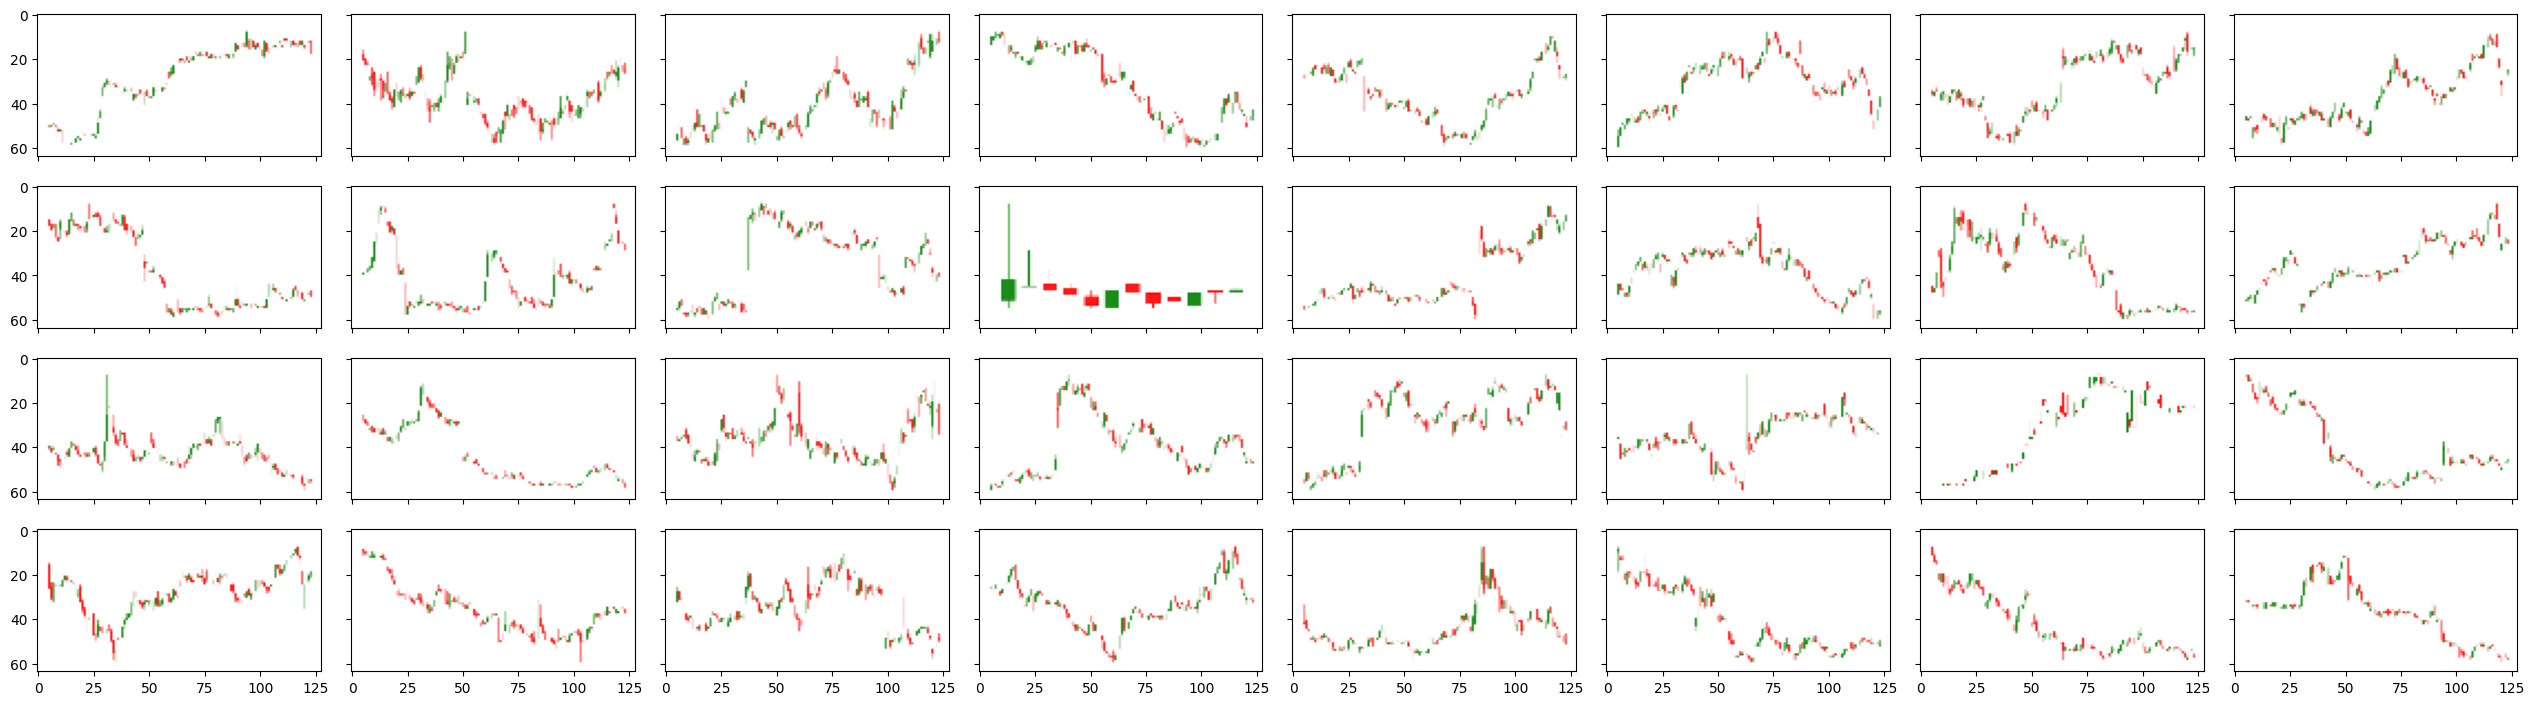

In [ ]:
sample_images = x_train[:32]

fig = plt.figure(figsize=(32., 16.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),
                 axes_pad=0.3,
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

In [ ]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(64, 128), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size
      self.X = X
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle

      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = tf.identity(self.X[idx])#self.X[idx].copy()

      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)

      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255

    return X_batch, y_batch

  def __createMask(self, img):
    # Get the image dimensions
    height, width = img.shape[:2]

    # Create a mask where the right half is 0 (black) and the left half is 1 (white)
    mask = np.ones((height, width), dtype=np.float32)
    mask[:, -25:] = 0  # Set the right half of the mask to 0

    # Apply the mask to the image
    masked_image = img * mask[:, :, np.newaxis]  # Apply the mask to all color channels

    return masked_image


In [ ]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

In [ ]:
traingen.__len__()

80

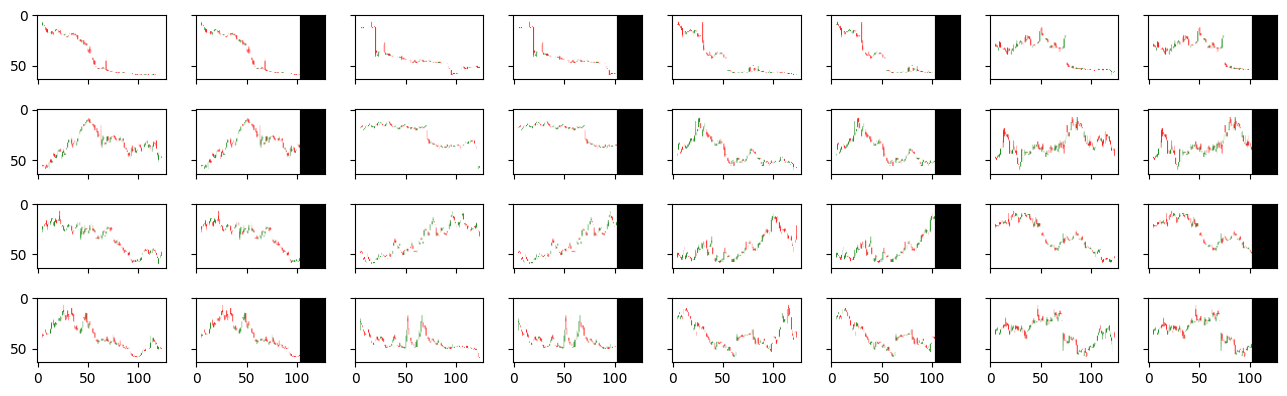

In [ ]:
## Examples
sample_idx = 4

sample_masks, sample_labels = traingen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

## Autoencoder-Decoder Model

In [ ]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_true_f = tf.cast(y_true_f, dtype=tf.float64)
    y_pred_f = keras.backend.flatten(y_pred)
    y_pred_f = tf.cast(y_pred_f, dtype=tf.float64)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [ ]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(64, 128,3)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs)
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2)
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3)
    print(pool4.shape)
    print(conv4.shape)

    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [ ]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
# Loss: Mean absolute error difference in pixel values
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])

(None, 4, 8, 256)
(None, 8, 16, 256)


# Train

In [ ]:
len(traingen)

80

In [ ]:
_ = model.fit(traingen,
          validation_data=testgen,
          epochs=20,
          steps_per_epoch=len(traingen)-1,
          validation_steps=len(testgen))

Epoch 1/20


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

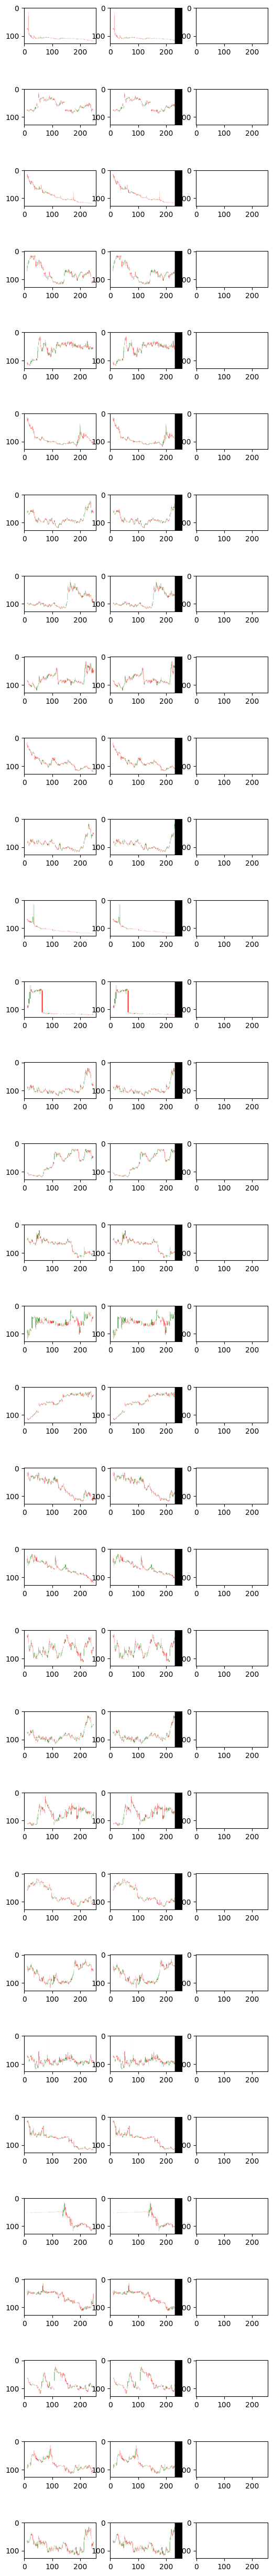

In [ ]:
## Test examples
rows = 32
sample_idx = 3
sample_images, sample_labels = traingen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

for i in range(32):
  impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
  axs[i][0].imshow(sample_labels[i])
  axs[i][1].imshow(sample_images[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()